In [1]:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_name = 'opt-6.7b' #'llama3-8b'
checkpoint_path = '../models/opt-6.7b' #'../models/llama3-8b'
data_path = 'fancyzhx/ag_news'

# Step1：Load Model and Data

In [2]:
from transformers import OPTForCausalLM,AutoModelForCausalLM
from transformers import AutoTokenizer

model = AutoModelForCausalLM.from_pretrained(checkpoint_path, device_map=device, torch_dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path, device_map=device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/qw127/anaconda3/envs/wqs/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
from datasets import load_dataset
dataset = load_dataset( 'fancyzhx/ag_news')

print("Dataset Info:")
print(dataset)

Dataset Info:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [5]:
#500 samples are taken from each label for easy observation.
#World
label_0_dataset = dataset['train'].filter(lambda example: example['label'] == 0)
label_0_texts = label_0_dataset['text'][:500]
#Sports
label_1_dataset = dataset['train'].filter(lambda example: example['label'] == 1)
label_1_texts = label_1_dataset['text'][:500]
#Bussiness
label_2_dataset = dataset['train'].filter(lambda example: example['label'] == 2)
label_2_texts = label_2_dataset['text'][:500]
#Sci/Tech
label_3_dataset = dataset['train'].filter(lambda example: example['label'] == 3)
label_3_texts = label_3_dataset['text'][:500]

# Step2：Collect Activation

In [6]:
import torch
import re

activations = []

def get_activation(name, activation_dict):
    def hook(model, input, output):
        activation_dict[name] = input[0].detach().cpu()
    return hook

def register_act_hooks(model, model_name, activation_dict):
    hooks = []
    for name, layer in model.named_modules():
        if "opt" in model_name:
            if isinstance(layer, torch.nn.ReLU):
                hooks.append(layer.register_forward_hook(get_activation(name, activation_dict)))
            
        elif "llama" in model_name:
            if isinstance(layer, torch.nn.SiLU):
                hooks.append(layer.register_forward_hook(get_activation(name, activation_dict)))
                
    return hooks

def remove_hooks(hooks):
    for hook in hooks:
        hook.remove()


data=label_0_texts+label_1_texts+label_2_texts+label_3_texts

# hook activation
for i in range(len(data)):
    prompt = data[i]
    tokenized_input = tokenizer(prompt, return_tensors="pt").to(device)
    
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s.,!?;:]', '', prompt)
    tokenized_input = tokenizer(cleaned_text, return_tensors="pt", max_length=256, truncation=True).to(device)
    
    activation_dict = {}

    hooks = register_act_hooks(model, model_name, activation_dict)

    with torch.no_grad():
        outputs = model(**tokenized_input)
        
    activations.append(activation_dict)

    remove_hooks(hooks)

In [8]:
# Choose any layer
Layer_num = 25
layer_act=[]
sentence_lenth=[]
for i in range(len(activations)):
    if "opt" in model_name:
        str_act="model.decoder.layers."+str(Layer_num)+".activation_fn"
    elif "llama" in model_name:
        str_act="model.layers."+str(Layer_num)+".mlp.act_fn"
        
    tensor = activations[i][str_act].cpu()
    layer_act.append(tensor.squeeze(0))
    if "opt" in model_name:
        m=tensor.size(0)
    elif "llama" in model_name:
        m=tensor.size(1)
    sentence_lenth.append(m)
A_tensor = torch.cat(layer_act, dim=0)

# Step3：Calculate Sentence-wise Core Neurons

In [9]:
if "opt" in model_name:
    neuron_num = model.model.decoder.layers[0].fc1.weight.size(0)
elif "llama" in model_name:
    neuron_num = model.model.layers[0].mlp.down_proj.weight.size(1)

In [10]:
sentence=[]
num=0
# sentence-wise and token-wise sparisity
sparisity = 0.4
token_sparisity = 0.2

for i in range(len(sentence_lenth)):
    lenth=sentence_lenth[i]
    list_now=list(range(num, num+lenth))
    sentence.append(list_now)
    num=num+lenth

act_all=(A_tensor).cpu()
count_act_all = (act_all > 0).sum(dim=1)
sorted_values, sorted_indices = torch.sort(act_all, dim=1, descending=True)

top50_indices=[]
for i in range(act_all.size(0)):
    indices = sorted_indices[i, :int(torch.round(count_act_all[i] * token_sparisity))]
    top50_indices.append(indices.tolist())

SEN_CORE=[]
for i in range(len(sentence)):
    cluster5= sentence[i]
    act_clu =  [top50_indices[i] for i in cluster5]
    data_flattened = [item for sublist in act_clu for item in sublist]
    data_flattened=torch.tensor(data_flattened)
    unique_numbers, counts = data_flattened.unique(return_counts=True, sorted=True)

    sorted_indices = torch.argsort(counts, descending=True)
    sorted_numbers = unique_numbers[sorted_indices]
    sorted_counts = counts[sorted_indices]
    neuron_remained = int(neuron_num * sparisity)
    SEN_CORE.append(sorted_numbers[:neuron_remained].numpy())
    

# Step4: Similarity Proof

/home/qw127/anaconda3/envs/wqs/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [16383] will be ignored
  warnings.warn(


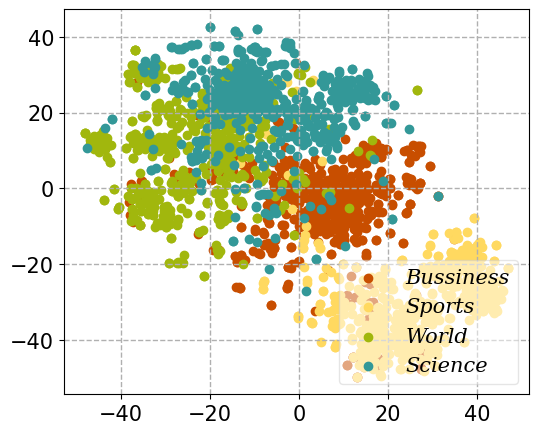

In [11]:
import numpy as np
import torch
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.manifold import TSNE

data = SEN_CORE


mlb = MultiLabelBinarizer(classes=range(0, 16383))
encoded_data = mlb.fit_transform(data)

k = 4  
kmeans = KMeans(n_clusters=k, random_state=1)
clusters = kmeans.fit_predict(encoded_data)

tsne = TSNE(n_components=2,perplexity=37,random_state=0)
embedded = tsne.fit_transform(encoded_data)

plt.figure(figsize=(6, 5))

cluster_points = embedded[list(range(0,500))]
plt.scatter(cluster_points[:, 0], cluster_points[:, 1],color='#C84E00', label=f"Bussiness")

cluster_points = embedded[list(range(500,1000))]
plt.scatter(cluster_points[:, 0], cluster_points[:, 1],color='#FFD960', label=f"Sports")

cluster_points = embedded[list(range(1000,1500))]
plt.scatter(cluster_points[:, 0], cluster_points[:, 1],color='#A1B70D', label=f"World")

cluster_points = embedded[list(range(1500,2000))]
plt.scatter(cluster_points[:, 0], cluster_points[:, 1],color='#339898', label=f"Science")

font_properties = FontProperties(family='serif', style='italic', size=15)
plt.legend(loc='lower right',prop=font_properties, framealpha=0.5)
plt.tick_params(labelsize=15)
plt.rcParams.update({'font.size':15}) 
plt.grid(True, linestyle='--', linewidth=1)
plt.show()